# COP Graphs for Phil Kaluza Fujistsu 15RLS3 in Seward

In [1]:
import datetime
from datetime import timedelta
import io
from dateutil.parser import parse
import urllib
import requests
import pandas as pd
import numpy as np
import statsmodels.formula.api as sm
import itertools
from scipy.optimize import curve_fit
import astral

###################### Matplotlib #######################
# import matplotlib pyplot commands
from matplotlib.pyplot import *
 
# Show Plots in the Notebook
%matplotlib inline
 
# 'style' the plot like fivethirtyeight.com website
style.use('bmh')

In [2]:
rcParams['figure.figsize']= (9, 6)   # set Chart Size
rcParams['font.size'] = 14            # set Font size in Chart

base_url = 'https://bmon.analysisnorth.com/api/v1/readings/{}/'

def count_cycles(ser):
    '''Counts the Off cycles in a series.
    '''
    THRESH = 200.   # Must fall below this Watt level to be considered turning off
    dfp = pd.DataFrame({'power': ser.dropna()})
    dfp['state'] =  dfp.power > THRESH
    dfp['prior_state'] = dfp.state.shift()
    dfp['off_event'] = np.where((dfp.state==False) & (dfp.prior_state==True), 1, 0)
    return dfp.off_event.sum()
    

### All Night COPs

Calculates the COP for each night, considering energy use from 1 hour
after sunset to 1/2 hour after sunrise.

In [3]:
# Download the needed sensor data.
sensors = [
    ('phil_hp_pwr_17_pulse', 'ms_power'),
    ('phil_port_pwr_16_pulse', 'spc_power'),
    ('phil_hp_pwr_10187_temp', 'temp_out'),
    ('phil_hp_pwr_354_temp', 'temp_downstairs'),
    ('phil_hp_pwr_6070_temp', 'temp_upstairs'),    
]
params = {'start_ts': '2018-01-23'}
dfs = []
for sensor_id, lbl in sensors:
    print(sensor_id)
    resp = requests.get(base_url.format(sensor_id), params=params).json()
    df = pd.DataFrame(resp['data']['readings'], columns=['ts', lbl])
    df.set_index('ts', inplace=True)
    dfs.append(df)
df = pd.concat(dfs, axis=1)
df.index = pd.to_datetime(df.index)

phil_hp_pwr_17_pulse
phil_port_pwr_16_pulse
phil_hp_pwr_10187_temp
phil_hp_pwr_354_temp
phil_hp_pwr_6070_temp


In [4]:
exclude_days = [
    '2018-04-17',      # exhaust fans On
    '2018-04-19',      # Wired Remote was disabled
]
divide_date = '2018-04-18'

UA = 29.0
MASS_COEFF = 577   # W / (deg F / hr), from prior 8 day coheat period
UP_WTG = 0.55   # for heat loss

# convert list of exclude days and divide date to Python dates
exclude_days = [parse(d) for d in exclude_days]
divide_date = parse(divide_date)

# Sunrise / Sunset calculator object
city_name = 'Anchorage'

a = astral.Astral()
a.solar_depression = 'civil'

city = a[city_name]

# we increment the date immediately in the loop, so need to take-away
# a day to start with.
dt1 = parse(params['start_ts']) - timedelta(days=1)

out_temps = [[], []]
out_temps_adj = [[], []]
cops = [[], []]
delta_ts = [[], []]
cycle_rates = [[], []]
dates = [[], []]
short_dates = [[], []]

while True:
    
    dt1 += timedelta(days=1)
    
    # stop if we have reached today
    if dt1 >= datetime.datetime.now() - timedelta(days=1):
        break
    
    # check to see whether this day should be exluded
    if dt1 in exclude_days:
        dt1 += timedelta(days=1)
        continue

    # print(dt1)
    dt2 = dt1 + timedelta(days=1)
    
    # determine what output array index to use based on where this date
    # falls relative to the dividing date.
    dix = 0 if dt1 < divide_date else 1
    
    # sunset on dt1
    try:
        sun = city.sun(date=dt1, local=True)
        dt_start = sun['sunset'] + timedelta(hours=1)
    except:
        # Errors occur in astral on long daylight days
        # Start at 11 pm
        dt_start = dt1 + timedelta(hours=23)
        
    # sunrise on dt2
    try:
        sun = city.sun(date=dt2, local=True)
        dt_end = sun['sunrise'] + timedelta(minutes=30)
    except:
        # Errors occur in astral on long daylight days
        # Start at 5 am
        dt_end = dt2 + timedelta(hours=5)
    
    fmt = '%Y-%m-%d %H:%M:%S'
    dfd = df.loc[dt_start.strftime(fmt) : dt_end.strftime(fmt)]
    
    # No data for the day, go on to next day
    if len(dfd) == 0:
        continue
        
    # calculate averages
    avgs = dfd.mean()
    
    # Large error in days with low power usage
    if avgs.ms_power < 200:
        continue
    
    try:
        # Calculate downstairs and upstairs temperature spread over
        # the interval
        down_spread = dfd.temp_downstairs.max() - dfd.temp_downstairs.min()
        up_spread = dfd.temp_upstairs.max() - dfd.temp_upstairs.min()

        # Calculate indoor temperature change over the interval:
        down_start = dfd.temp_downstairs.dropna()[0]
        down_end = dfd.temp_downstairs.dropna()[-1]
        up_start = dfd.temp_upstairs.dropna()[0]
        up_end = dfd.temp_upstairs.dropna()[-1]
        tmp_chg = (down_end + up_end - down_start - up_start) / 2.0    # equal mass weighting
        hrs_in_per = (dfd.index[-1] - dfd.index[0]).total_seconds() / 3600.

        # Calculate the cycles per hour in the period
        cyc_per_hour = count_cycles(dfd.ms_power) / hrs_in_per
        
    except:
        # some of the data was missing, go on to next day
        continue
    
    if abs(tmp_chg) < 3.0 and \
    (np.isnan(avgs.spc_power) or avgs.spc_power < 20.0) and \
    down_spread < 4.0 and up_spread < 4.0:
        avg_indoor = UP_WTG * avgs.temp_upstairs + (1.0 - UP_WTG) * avgs.temp_downstairs
        delta_t = avg_indoor - avgs.temp_out
        temp_out_adj = 70.0 - delta_t
        heat_load = UA * delta_t + MASS_COEFF * tmp_chg / hrs_in_per
        cop = heat_load / avgs.ms_power
        out_temps[dix].append(avgs.temp_out)
        out_temps_adj[dix].append(temp_out_adj)
        cops[dix].append(cop)
        delta_ts[dix].append(delta_t)
        cycle_rates[dix].append(cyc_per_hour)
        dates[dix].append(dt1)
        dt_short = str(dt1)[:10]
        short_dates[dix].append(dt_short)
        #print(f"{dt_short} {temp_out_adj:.2f} F, {cyc_per_hour:.1f} cycles/hr, COP = {cop:.2f}")

df_results = pd.DataFrame(
    {
      'Date': short_dates[0] + short_dates[1],
      'Adj Outdoor Temp': out_temps_adj[0] + out_temps_adj[1],
      'Cycles/Hour': cycle_rates[0] + cycle_rates[1],
      'COP': cops[0] + cops[1],
      'Remote Thermostat': len(cops[0]) * [False] + len(cops[1]) * [True]
    },
)
df_results = df_results[['Date', 'Adj Outdoor Temp', 'Cycles/Hour', 'COP', 'Remote Thermostat']]
df_results.set_index('Date', inplace=True)
pd.options.display.max_rows = 999

df_results.head()

,Adj Outdoor Temp,Cycles/Hour,COP,Remote Thermostat
Date,,,,
2018-01-23,16.954374,0.303490,2.225037,False
2018-01-24,12.798683,0.243659,1.987830,False
2018-01-25,15.606877,0.306550,2.083570,False
2018-01-26,26.077766,0.246141,2.586856,False
2018-01-27,14.249632,0.185660,2.231214,False


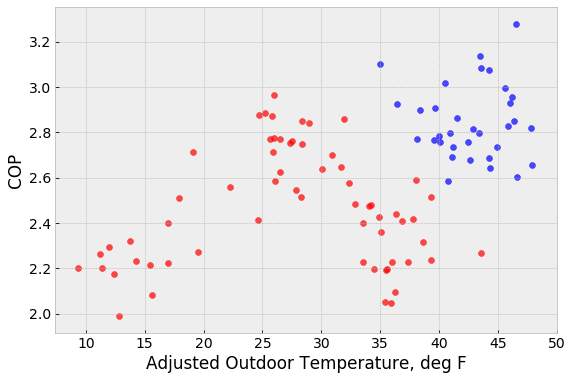

In [5]:
# Adjusted outdoor temperature equals to the actual delta-T
# with a 70 deg F indoor temperature.
sizes = np.array(cycle_rates) * 30
scatter(out_temps_adj[0], cops[0], c="red", alpha=0.7)
scatter(out_temps_adj[1], cops[1], c="blue", alpha=0.7)
xlabel('Adjusted Outdoor Temperature, deg F')
ylabel('COP');

### Size of Dot indicates Cycle Rate per Hour

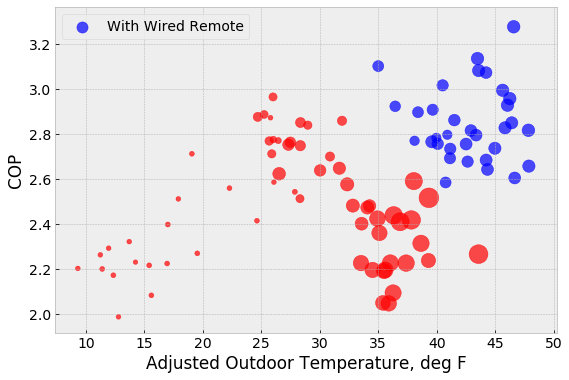

In [6]:
# Adjusted outdoor temperature equals to the actual delta-T
# with a 70 deg F indoor temperature.
sizes = [[], []]
sizes[0] = (np.array(cycle_rates[0]) + 0.5) * 30
sizes[1] = (np.array(cycle_rates[1]) + 0.5) * 30
scatter(out_temps_adj[0], cops[0], s=sizes[0], c="red", alpha=0.7)
scatter(out_temps_adj[1], cops[1], s=sizes[1], c="blue", alpha=0.7, label='With Wired Remote')
legend(loc='upper left')
xlabel('Adjusted Outdoor Temperature, deg F')
ylabel('COP');

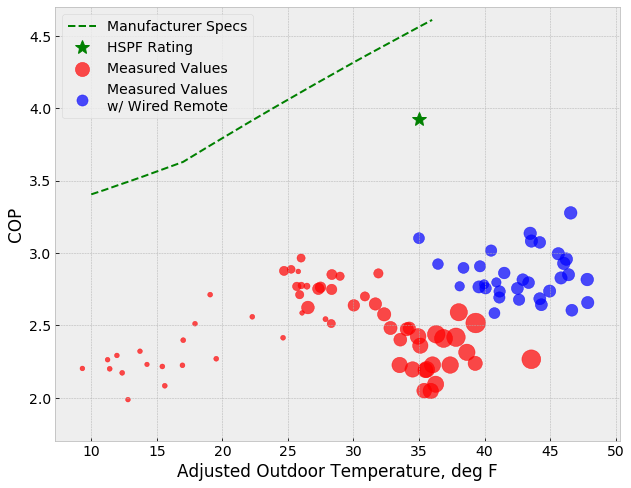

In [7]:
# COP from specs.  See "Dropbox/Heat_Pump/models/hp_model.ipynb"
# NOTE:  THIS INCLUDES a 5% reduction in the COP to account for defrost
# at temperatures below 37 deg F.
specs = [
    (10, 3.406),
    (11, 3.436),
    (12, 3.468),
    (13, 3.499),
    (14, 3.531),
    (15, 3.564),
    (16, 3.597),
    (17, 3.630),
    (18, 3.685),
    (19, 3.740),
    (20, 3.794),
    (21, 3.848),
    (22, 3.902),
    (23, 3.955),
    (24, 4.008),
    (25, 4.060),
    (26, 4.112),
    (27, 4.164),
    (28, 4.215),
    (29, 4.266),
    (30, 4.317),
    (31, 4.367),
    (32, 4.416),
    (33, 4.465),
    (34, 4.514),
    (35, 4.563),
    (36, 4.611),        # about 213 W input
]
temp_sp, cop_sp = zip(*specs)
figure(figsize=(9,7))
plot(temp_sp, cop_sp, 'g--', label='Manufacturer Specs')
plot(35.0, 3.93, 'b*', markersize=15, color='green', label='HSPF Rating')
scatter(out_temps_adj[0], cops[0], color='red', s=sizes[0], alpha=0.7, label='Measured Values')
scatter(out_temps_adj[1], cops[1], alpha=0.7, color='blue', s=sizes[1], label='Measured Values\nw/ Wired Remote')
legend(loc='upper left')
ylim(1.7, 4.7)

xlabel('Adjusted Outdoor Temperature, deg F')
ylabel('COP')
tight_layout();

## Binned COP and Outdoor Temperature using Altair

In [8]:
import altair as alt

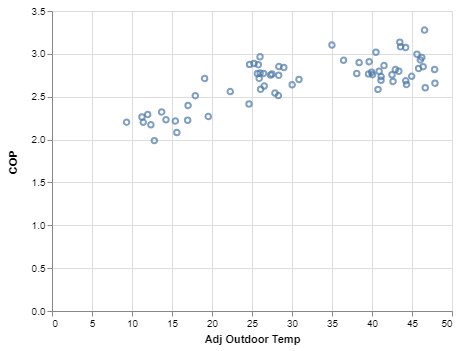

In [9]:
# Make a graph that includes points 31 F or below and those
# points where the remote thermostat was being used.
dfb = df_results[(df_results['Adj Outdoor Temp'] <= 31.0) | (df_results['Remote Thermostat'] == True)]
alt.Chart(dfb).mark_point().encode(
    x = 'Adj Outdoor Temp',
    y = 'COP'
)

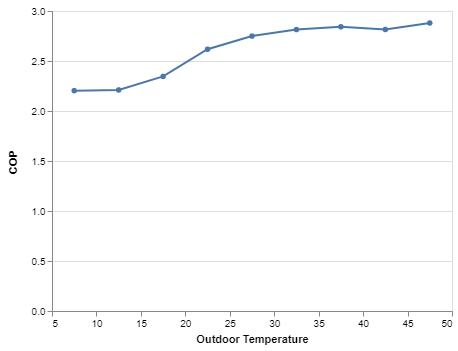

In [10]:
line = alt.Chart(dfb).mark_line(point=True).encode(
    x = alt.X('Adj Outdoor Temp', bin=alt.Bin(maxbins=10), axis=alt.Axis(title='Outdoor Temperature')),
    y = alt.Y('mean(COP)', axis=alt.Axis(title='COP')),
)

#middle_50 = alt.Chart(dfb).mark_area(opacity=0.3).encode(
#    x = alt.X('Adj Outdoor Temp', bin=alt.Bin(maxbins=10)),
#    y=alt.Y('q1(COP)', axis=alt.Axis(title='COP')),
#    y2='q3(COP)'
#)

line

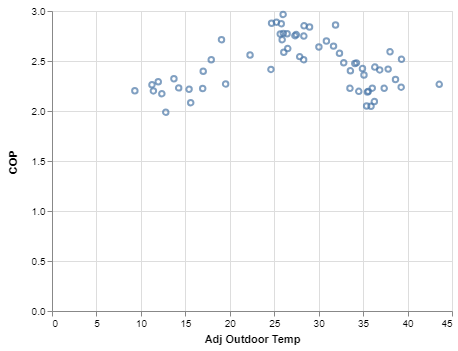

In [11]:
# Now only look at points without the remote thermostat
dfb = df_results[df_results['Remote Thermostat'] == False]
alt.Chart(dfb).mark_point().encode(
    x = 'Adj Outdoor Temp',
    y = 'COP'
)

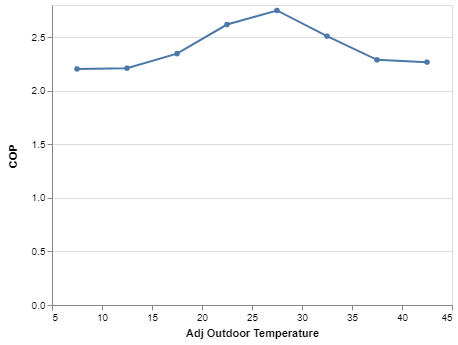

In [12]:
alt.Chart(dfb).mark_line(point=True).encode(
    x = alt.X('Adj Outdoor Temp', bin=alt.Bin(maxbins=10), axis=alt.Axis(title='Adj Outdoor Temperature')),
    y = alt.Y('mean(COP)', axis=alt.Axis(title='COP')),
)

It looks like Altair is plotting against the center of the
temperature bin. It would be more accurate to plot against the
average of the temperature values of the points inside the bin,
which may deviate from the center for uneven distribution of points.

## Explictly Calculate Bin Averages and Plot

In [13]:
def bin_averages(df, bin_width = 5.0):
    """For DataFrame df, calculate average temperatures and COPs for bins
    of outdoor temperature of width 'bin_width' deg F.  Return a DataFrame
    with the averaged values.
    """
    dfc = df.copy()
    # calculate the bin for each row
    dfc['temp_bin'] = dfc['Adj Outdoor Temp'] // bin_width
    
    # average by bins
    dfa = dfc.groupby('temp_bin').mean()
    dfa = dfa[['Adj Outdoor Temp', 'COP']]
    dfa.columns = ['temperature', 'cop']
    return dfa
    

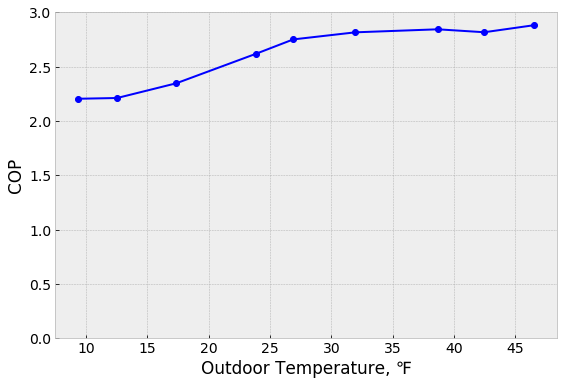

In [14]:
# Make a graph that includes points 31 F or below and those
# points where the remote thermostat was being used.
dfb = df_results[(df_results['Adj Outdoor Temp'] <= 31.0) | (df_results['Remote Thermostat'] == True)]
dfr = bin_averages(dfb)
plot(dfr.temperature, dfr.cop, 'b-', marker='o')
xlabel('Outdoor Temperature, ℉')
ylabel('COP')
ylim(0, 3.0)
dfr['source'] = 'Seward, Kaluza w/ Remote Therm'
dfr['field_study'] = True
dfr['hspf'] = 13.4
dfr.to_pickle('temp_cop_kaluza_remote.pkl')

In [15]:
temp_cop_external = list(zip(dfr.temperature, dfr.cop))
temp_cop_external

[(9.323180679405695, 2.2032414599781482),
 (12.532492677910634, 2.21025799131429),
 (17.35814819599886, 2.345697136246265),
 (23.870238394028032, 2.6175567164894855),
 (26.894926826979138, 2.749132114515984),
 (31.963711653531835, 2.814352844937004),
 (38.68488134262254, 2.8421298584971897),
 (42.47864094035299, 2.815108923560848),
 (46.55942277427139, 2.8801912519331694)]

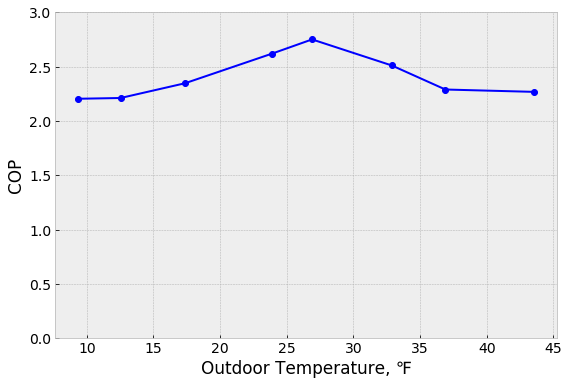

In [16]:
# Graph with no remote thermostat
dfb = df_results[df_results['Remote Thermostat'] == False]
dfr = bin_averages(dfb)
plot(dfr.temperature, dfr.cop, 'b-', marker='o')
xlabel('Outdoor Temperature, ℉')
ylabel('COP')
ylim(0, 3.0)
dfr['source'] = 'Seward, Kaluza'
dfr['field_study'] = True
dfr['hspf'] = 13.4
dfr.to_pickle('temp_cop_kaluza.pkl')

In [17]:
temp_cop_internal = list(zip(dfr.temperature, dfr.cop))
temp_cop_internal

[(9.323180679405695, 2.2032414599781482),
 (12.532492677910634, 2.21025799131429),
 (17.35814819599886, 2.345697136246265),
 (23.870238394028032, 2.6175567164894855),
 (26.894926826979138, 2.749132114515984),
 (32.873171329868896, 2.509495489396102),
 (36.89277174149361, 2.288341826445965),
 (43.56237357142844, 2.266642264933841)]

### Compute Annual COP

In [18]:
# Used to read TMY3 file
base_url = 'http://ak-energy-data.analysisnorth.com/'

def get_df(file_path):
    """Returns a Pandas DataFrame that is found at the 'file_path'
    below the Base URL for accessing data.  The 'file_path' should end
    with '.pkl' and points to a pickled, compressed (bz2), Pandas DataFrame.
    """
    b = requests.get(urllib.parse.urljoin(base_url, file_path)).content
    df = pd.read_pickle(io.BytesIO(b), compression='bz2')
    return df

In [19]:
# Function to calculate annual COP
def cop_annual(temp_cop_points, df_tmy, balance_temp):
    # Extend temperature/cop points to cold and warm temperatures.
    # Not very relevant for this data set as few important temperatures
    # outside the bounds
    t_c_mod = temp_cop_points.copy()
    t_c_mod.insert(0, (-10, 1.0))    # linear down to cop = 1 at -10 F
    t_c_mod.append((70, t_c_mod[-1][1]))   # Extend last COP out to 70 F
    # split into separate temperature and COP arrays
    temps, cops = zip(*t_c_mod)
    # Make an hourly array of cops by interpolating COP values from outdoor
    # temperatures
    cop_hourly = np.interp(df_tmy.db_temp, temps, cops)
    
    load_hourly = balance_temp - df_tmy.db_temp
    load_hourly = load_hourly.where(load_hourly > 0.0, 0.0)
    elec_hourly = load_hourly / cop_hourly
    
    cop_avg = sum(load_hourly) / sum(elec_hourly) 
    
    return cop_avg

In [20]:
tmy3_id = 702770    # Seward
df_tmy = get_df(f'wx/tmy3/proc/{tmy3_id}.pkl')
cop_annual(temp_cop_internal, df_tmy, 60)

2.385693410677314

In [21]:
tmy3_id = 702770    # Seward
df_tmy = get_df(f'wx/tmy3/proc/{tmy3_id}.pkl')
cop_annual(temp_cop_external, df_tmy, 60)

2.678631308975593

## Relationship between Stable Compressor Power and Outdoor Temperature

In [22]:
df.head()

,ms_power,spc_power,temp_out,temp_downstairs,temp_upstairs
2018-01-23 00:00:51,637.5,NaN,NaN,NaN,NaN
2018-01-23 00:01:13,NaN,NaN,NaN,72.77,NaN
2018-01-23 00:01:19,NaN,NaN,21.43,NaN,NaN
2018-01-23 00:01:22,NaN,NaN,NaN,NaN,70.0
2018-01-23 00:02:51,600.0,NaN,NaN,NaN,NaN


In [23]:
dfst = df[['ms_power', 'temp_out']].copy()
dfst_m = dfst.rolling('10min', min_periods=3).mean()
dfst_s = dfst.rolling('10min', min_periods=3).std().drop(columns=['temp_out'])
dfst_s.columns = ['ms_power_std']
dfst_a = dfst.rolling('10min', min_periods=3).apply(lambda x: x[-1]).drop(columns=['temp_out'])
dfst_a.columns = ['ms_power_actual']
dfst = pd.concat([dfst_m, dfst_s, dfst_a], axis=1).dropna()
dfst.head()

,ms_power,temp_out,ms_power_std,ms_power_actual
2018-01-23 00:06:51,628.125,21.53300,18.750000,637.5
2018-01-23 00:08:51,630.000,21.52975,16.770510,637.5
2018-01-23 00:10:51,622.500,21.49180,20.539596,600.0
2018-01-23 00:12:51,622.500,21.43780,20.539596,600.0
2018-01-23 00:14:51,630.000,21.38120,31.374751,675.0


(0, 1200)

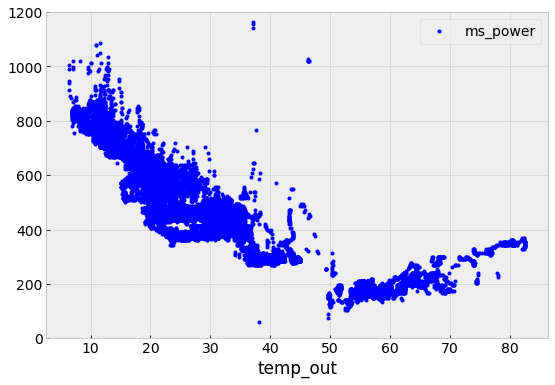

In [24]:
dff = dfst.query('ms_power > 60 and ms_power_std < 50')
dff.plot(x='temp_out', y='ms_power', style='b.')
ylim(0, 1200)

Text(0.5,0,'Outdoor Temp, deg F')

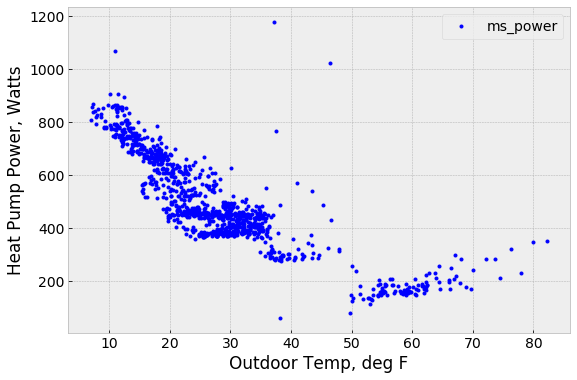

In [25]:
df_sm = dff.resample('1H').mean().dropna()
df_sm.plot(x='temp_out', y='ms_power', style='b.')
ylabel('Heat Pump Power, Watts')
xlabel('Outdoor Temp, deg F')

In [26]:
df_sm.query('ms_power > 160 and ms_power < 200')

,ms_power,temp_out,ms_power_std,ms_power_actual
2018-06-01 19:00:00,171.250000,66.175567,34.759406,162.500000
2018-06-25 22:00:00,191.571429,55.543376,35.432495,197.142857
2018-06-25 23:00:00,184.627660,54.409420,35.013680,181.914894
2018-06-26 00:00:00,171.750000,53.488461,35.507478,172.500000
2018-06-26 17:00:00,187.500000,62.436300,39.368743,187.500000
2018-06-26 22:00:00,183.177966,55.595781,36.285369,183.050847
2018-06-27 17:00:00,172.659000,59.140000,37.073912,147.540000
2018-06-27 18:00:00,179.156952,59.463683,39.466447,182.540000
2018-06-28 17:00:00,188.272451,58.987981,36.926271,190.483125
2018-06-28 18:00:00,163.649602,57.205197,26.562976,161.305167


## What Power Levels does the Heat Pump Operate At?

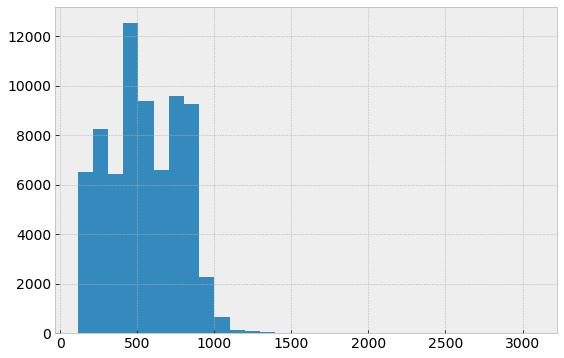

In [27]:
df.query('ms_power > 100').ms_power.hist(bins=30)

## Plot a Cycling Period against Average Power in that Period

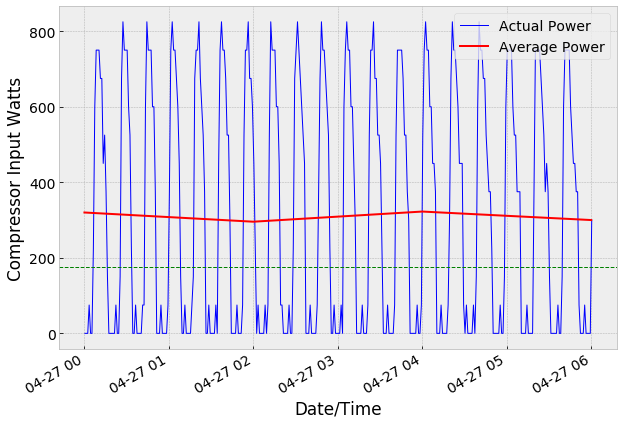

In [28]:
figure(figsize=(10,7))
df['2018-04-27':'2018-04-27 6:00']['ms_power'].dropna().plot(style='b-', label='Actual Power', linewidth=1.0)
df['2018-04-27':'2018-04-27 6:00'].resample('2H').mean()['ms_power'].plot(style='r-', label='Average Power')
gca().axhline(175, linestyle='--', color='green', linewidth=1)
legend(loc='upper right')
ylabel('Compressor Input Watts')
xlabel('Date/Time');

The dashed green line shows the minimum compressor input power according to the specifications.
The average power consumption (red line) is far above that level.  The compressor is cycling
between Off and 800 Watts to meet the load instead of ramping down to a lower speed.

Outdoor Temperature averaged about 33 deg F during this period.  Indoor Temperature near the Indoor Unit was about 69 deg F.